# Deep Learning: Feed-Forward model to Predict scores

## Import Libraries

In [0]:
!pip install torch

  Using cached torch-2.0.1-cp39-cp39-manylinux1_x86_64.whl (619.9 MB)
  Using cached nvidia_cuda_nvrtc_cu11-11.7.99-2-py3-none-manylinux1_x86_64.whl (21.0 MB)
  Using cached nvidia_curand_cu11-10.2.10.91-py3-none-manylinux1_x86_64.whl (54.6 MB)
  Using cached nvidia_cuda_runtime_cu11-11.7.99-py3-none-manylinux1_x86_64.whl (849 kB)
  Using cached nvidia_cuda_cupti_cu11-11.7.101-py3-none-manylinux1_x86_64.whl (11.8 MB)
  Using cached nvidia_cusparse_cu11-11.7.4.91-py3-none-manylinux1_x86_64.whl (173.2 MB)
  Using cached nvidia_cublas_cu11-11.10.3.66-py3-none-manylinux1_x86_64.whl (317.1 MB)
  Using cached nvidia_cusolver_cu11-11.4.0.1-2-py3-none-manylinux1_x86_64.whl (102.6 MB)
  Using cached nvidia_nccl_cu11-2.14.3-py3-none-manylinux1_x86_64.whl (177.1 MB)
  Using cached triton-2.0.0-1-cp39-cp39-manylinux2014_x86_64.manylinux_2_17_x86_64.whl (63.3 MB)
  Using cached sympy-1.12-py3-none-any.whl (5.7 MB)
  Using cached nvidia_nvtx_cu11-11.7.91-py3-none-manylinux1_x86_64.whl (98 kB)
  Usin

In [0]:
from pyspark.sql import SparkSession
import pyspark.pandas as ps
from pyspark.ml.feature import StringIndexer

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import random_split, TensorDataset, DataLoader

## Create Spark Dataframe and apply transformations

In [0]:
# Create a Spark session
spark = SparkSession.builder.getOrCreate()

# Read a table into a Spark DataFrame
spark_df = spark.table("football.gold_dl_table")

### Label encodings for categorical variables

In [0]:
# List of categorical columns to encode
categorical_cols = ["coach_id_home", "league_id", "season", "coach_id_away"]

# Loop through categorical columns and apply StringIndexer
for col in categorical_cols:
    indexer = StringIndexer(inputCol=col, outputCol=col + "Index")
    spark_df = indexer.fit(spark_df).transform(spark_df)

In [0]:
spark_df = spark_df.drop(
    "fixture_date",
    "fixture_id",
    "referee",
    "venue_id",
    "status",
    "away_team_id",
    "home_team_id",
    "match_result",
    "coach_id_home",
    "coach_id_away",
    "league_id",
    "season",
)

spark_df = spark_df.dropna()

In [0]:
spark_df.show(10)

+----------+----------+--------------------+--------------------+------------------+-------------------+------------------+--------------+--------------+------------------+------------------+------------------+------------------+--------------+-----------+------------------+
|away_goals|home_goals|rank_team_faced_away|rank_team_faced_home|     total_shots_r|  prior_season_rank|      possession_r|red_cards_away|red_cards_home|        gk_saves_r|           fouls_r|   pass_accuracy_r|coach_id_homeIndex|league_idIndex|seasonIndex|coach_id_awayIndex|
+----------+----------+--------------------+--------------------+------------------+-------------------+------------------+--------------+--------------+------------------+------------------+------------------+------------------+--------------+-----------+------------------+
|         2|         0|                 8.0|                16.0|              3.25|0.35294117647058826|              1.14|           0.0|           0.0|               1.0|

## Create Training and Testing Set: Load

In [0]:
pandas_df = spark_df.toPandas()
pandas_df.head(5)

,away_goals,home_goals,rank_team_faced_away,rank_team_faced_home,total_shots_r,prior_season_rank,possession_r,red_cards_away,red_cards_home,gk_saves_r,fouls_r,pass_accuracy_r,coach_id_homeIndex,league_idIndex,seasonIndex,coach_id_awayIndex
0,2,0,8.0,16.0,3.250000,0.352941,1.14,0.00,0.0,1.000000,1.5000,1.226310,102.0,0.0,1.0,79.0
1,2,0,8.0,16.0,3.250000,0.352941,1.14,0.00,0.0,1.000000,1.5000,1.226310,102.0,0.0,1.0,354.0
2,2,3,13.5,11.0,1.102941,1.200000,0.90,0.25,0.0,1.333333,1.1875,0.973636,148.0,0.0,1.0,79.0
3,2,3,13.5,11.0,1.102941,1.200000,0.90,0.25,0.0,1.333333,1.1875,0.973636,52.0,0.0,1.0,79.0
4,2,3,13.5,11.0,1.102941,1.200000,0.90,0.25,0.0,1.333333,1.1875,0.973636,148.0,0.0,1.0,354.0


In [0]:
targets1 = pandas_df["away_goals"].values.flatten()
targets2 = pandas_df["home_goals"].values.flatten()

features = pandas_df.drop(["away_goals", "home_goals"], axis=1).values

In [0]:
test_size = int(0.08 * 22603)  # represents size of validation set
val_size = test_size
train_size = 22603 - test_size * 2
train_size, val_size, test_size

Out[14]: (18987, 1808, 1808)

In [0]:
dataset = torch.utils.data.TensorDataset(
    torch.tensor(features).float(),
    torch.tensor(targets1).unsqueeze(-1),
    torch.tensor(targets2).unsqueeze(-1),
)
train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])
batch_size = 256

In [0]:
train_loader = DataLoader(
    train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=False
)
val_loader = DataLoader(val_ds, batch_size * 2, num_workers=4, pin_memory=False)
test_loader = DataLoader(test_ds, batch_size * 2, num_workers=4, pin_memory=False)

In [0]:
for x, y1, y2 in test_loader:
    print(x.shape, y1.shape, y2.shape)
    break

torch.Size([512, 14]) torch.Size([512, 1]) torch.Size([512, 1])


In [0]:
train_loader

Out[18]: <torch.utils.data.dataloader.DataLoader at 0x7f689d1f4d60>

## Setup PyTorch Model

In [0]:
input_size = 14
output_size = 1

In [0]:
output_size = 1


class FootballModelMk2(nn.Module):
    def __init__(self, input_size, output_size):
        super().__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3_1 = nn.Linear(32, output_size)  # output for target1
        self.fc3_2 = nn.Linear(32, output_size)  # output for target2
        self.dp = nn.Dropout(0.5)
        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(32)

    def forward(self, x):
        x = F.relu(self.bn1(self.fc1(x)))
        x = self.dp(x)
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.dp(x)
        out1 = self.fc3_1(x)  # prediction for target1
        out2 = self.fc3_2(x)  # prediction for target2
        return out1, out2

In [0]:
crit = nn.L1Loss()  # criterion
opt_func = torch.optim.SGD  # optimizer function (w/o params or lr)

In [0]:
def fit(epochs, lr, model, train_loader, val_loader, crit, opt_func, device):
    history = []
    # define optimizer
    opt = opt_func(model.parameters(), lr=lr)
    # loop for num of epochs
    for epoch in range(epochs):
        # training per epoch (iterate through each batch)
        for inputs, target1, target2 in train_loader:
            # put inputs to the same device as model (GPU or CPU)
            inputs, target1, target2 = (
                inputs.to(device),
                target1.to(device),
                target2.to(device),
            )
            # using optimizer & loss
            opt.zero_grad()
            (outs1, outs2), (loss1, loss2) = step(inputs, target1, target2, model, crit)
            loss = (
                loss1 + loss2
            )  # consider if this is the appropriate way to handle multiple losses
            loss.backward()
            opt.step()
        # evaluate model on validation set every epoch
        val_results = evaluate(model, val_loader, crit, device)
        # printing as output every 5 epochs
        if (epoch + 1) % 5 == 0 or (epoch + 1) == epochs:
            print(f'Epoch #{epoch + 1} ==> Val Loss: {val_results["avg_loss"]}')
        history.append(val_results)
    return history


def evaluate(model, loader, crit, device):
    losses = []
    accuracies = []
    # define the tolerance level
    tol = 0.4
    model.eval()
    # tracking gradient not needed
    with torch.no_grad():
        # looping over data loader
        for inputs, target1, target2 in train_loader:
            inputs, target1, target2 = (
                inputs.to(device),
                target1.to(device),
                target2.to(device),
            )
            (outs1, outs2), (loss1, loss2) = step(
                inputs, target1, target2, model, crit, evaluate=True
            )
            loss = (
                loss1 + loss2
            )  # consider if this is the appropriate way to handle multiple losses
            losses.append(loss.item())
            acc1 = ((outs1 - target1).abs() <= tol).float().mean()
            acc2 = ((outs2 - target2).abs() <= tol).float().mean()
            accuracies.append((acc1 + acc2) / 2)  # average of the two accuracies

    avg_loss = sum(losses) / len(losses)
    avg_acc = sum(accuracies) / len(accuracies)  # compute average "accuracy"
    return {"avg_loss": avg_loss, "avg_acc": avg_acc}


# function to input features into model (used for training + validation)
def step(inputs, target1, target2, model, crit, evaluate=False):
    outs1, outs2 = model(inputs)
    loss1 = crit(outs1, target1)
    loss2 = crit(outs2, target2)
    return (outs1, outs2), (loss1, loss2)

### Use GPU if available

In [0]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [0]:
device

Out[24]: device(type='cpu')

In [0]:
model = FootballModelMk2(input_size, output_size).to(device)
model

Out[25]: FootballModelMk2(
  (fc1): Linear(in_features=14, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3_1): Linear(in_features=32, out_features=1, bias=True)
  (fc3_2): Linear(in_features=32, out_features=1, bias=True)
  (dp): Dropout(p=0.5, inplace=False)
  (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

### Visualization Setup

In [0]:
import matplotlib.pyplot as plt


def visualize(hist, acc=False):
    losses = [x["avg_loss"] for x in hist]
    accs = [x["avg_acc"] for x in hist]
    if acc:
        plt.plot(accs)
        plt.ylabel("Accuracy (%)")
        plt.title("Accuracy over Epochs")
    else:
        plt.plot(losses)
        plt.ylabel("Losses")
        plt.title("Losses over Epochs")
    plt.xlabel("Epochs")
    plt.show()

## Run Model

In [0]:
before_train = evaluate(model, train_loader, crit, device)
before_train

hist = [evaluate(model, val_loader, crit, device)]

In [0]:
hist += fit(25, 1e-3, model, train_loader, val_loader, crit, opt_func, device)

Epoch #5 ==> Val Loss: 2.579696022669474
Epoch #10 ==> Val Loss: 1.9158215745290121
Epoch #15 ==> Val Loss: 1.8791439374287924
Epoch #20 ==> Val Loss: 1.9340532302856446
Epoch #25 ==> Val Loss: 1.959981582959493


In [0]:
hist += fit(50, 1e-4, model, train_loader, val_loader, crit, opt_func, device)

Epoch #5 ==> Val Loss: 1.853825608889262
Epoch #10 ==> Val Loss: 1.8514896440505981
Epoch #15 ==> Val Loss: 1.8547861067454021
Epoch #20 ==> Val Loss: 1.8527833223342896
Epoch #25 ==> Val Loss: 1.8515203619003295
Epoch #30 ==> Val Loss: 1.8504618565241495
Epoch #35 ==> Val Loss: 1.8504992850621542
Epoch #40 ==> Val Loss: 1.8535820198059083
Epoch #45 ==> Val Loss: 1.8579405117034913
Epoch #50 ==> Val Loss: 1.854393180211385


In [0]:
after_train = evaluate(model, test_loader, crit, device)
after_train

Out[30]: {'avg_loss': 1.8504217688242595, 'avg_acc': tensor(0.3245)}

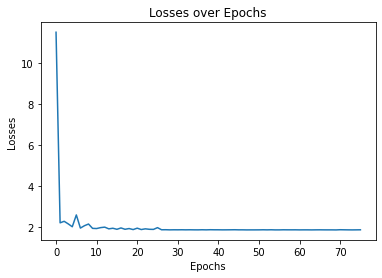

In [0]:
visualize(hist)

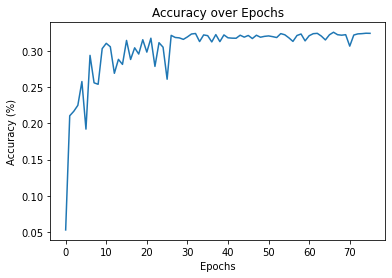

In [0]:
visualize(hist, acc=True)